## Imports

In [3]:
#import xwmt # This is xwmt-new
import numpy as np
import xarray as xr
import xgcm
from matplotlib import pyplot as plt

import sectionate as sec
import regionate as reg
import glob as glob
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

## Functions

In [4]:
z_suffixes = {
    "zstr": "z",
    "rho2": "rho2"
}
def ds_to_grid(ds, z_coord="zstr", xyloc="outer"):
    coords={
        'X': {'center': 'xh', xyloc: 'xq'},
        'Y': {'center': 'yh', xyloc: 'yq'}
    }
    if "z_l" in ds.dims:
        coords = {
            **coords,
            **{'Z': {'center': 'z_l', 'outer': 'z_i'}}
        }
    elif "rho2_l" in ds.dims:
        coords = {
            **coords,
            **{'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}}
        }
    boundary={"X":"periodic", "Y":"extend", "Z":"extend"}
    
    return xgcm.Grid(ds, coords=coords, boundary=boundary, autoparse_metadata=False)

def load_CM4p25(ds, og, diag_path=None, z_coord="zstr"):
    realm = "ocean"
    frequency = "annual"
    if diag_path is None:
        diag_path = "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_1pctCO2_C/gfdl.ncrc4-intel16-prod-openmp/pp/"
    else:
        diag_path = diag_path
    suffix = z_suffixes[z_coord]
    #ds = xr.open_mfdataset(f"{diag_path}/{realm}_{frequency}_{suffix}/ts/{frequency}/10yr/*.0341*.nc", chunks={'time':1}, decode_times=False).isel(time=[0])
    #og = xr.open_dataset(f"{diag_path}/{realm}_{frequency}_{suffix}/{realm}_{frequency}_{suffix}.static.nc")
    sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p25/c192_OM4_025_grid_No_mg_drag_v20160808_unpacked/ocean_hgrid.nc")
    
    ds = fix_grid_coords(ds, og, sg)
    return ds_to_grid(ds)

def fix_grid_coords(ds, og, sg):
    og['deptho'] = (
        og['deptho'].where(~np.isnan(og['deptho']), 0.)
    )
    
    ds = ds.assign_coords({
        'dxCv': xr.DataArray(
            og['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)
        ),
        'dyCu': xr.DataArray(
            og['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',)
        )
    }) 
    
    ds = ds.assign_coords({
        'areacello':xr.DataArray(og['areacello'].values, dims=("yh", "xh")),
        'geolon':   xr.DataArray(og['geolon'].values, dims=("yh", "xh")),
        'geolat':   xr.DataArray(og['geolat'].values, dims=("yh", "xh")),
        'geolon_u': xr.DataArray(og['geolon_u'].values, dims=("yh", "xq",)),
        'geolat_u': xr.DataArray(og['geolat_u'].values, dims=("yh", "xq",)),
        'geolon_v': xr.DataArray(og['geolon_v'].values, dims=("yq", "xh",)),
        'geolat_v': xr.DataArray(og['geolat_v'].values, dims=("yq", "xh",)),
        'geolon_c': xr.DataArray(og['geolon_c'].values, dims=("yq", "xq",)),
        'geolat_c': xr.DataArray(og['geolat_c'].values, dims=("yq", "xq",)),
        'deptho':   xr.DataArray(og['deptho'].values, dims=("yh", "xh",)),
    })
    return ds
    

## inputs

In [5]:
name = "Barents Sea"
lons = np.array([-25, -10, 0, 5, 15, 19, 19, 15, -15., -28])
lats = np.array([81, 80.5, 80, 79.5, 79, 73, 69, 65, 66, 68])

## Getting Annual CM41pct vmo, umo

In [6]:
base_path = (
    f"/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/"
    f"CM4_1pctCO2_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/"
)
var_realm = f"ocean_annual_z"
year_min = "0061"
year_max = "0090"
var_list = ["umo", "vmo"]
pattern    = f"{base_path}{var_realm}.*.[uv]mo.nc"
paths_all  = sorted(glob.glob(pattern))
path_vmo, path_umo = [], []
lo, hi     = int(year_min), int(year_max)

for path_i in (paths_all):
    min_year, max_year = path_i.split("/")[-1].split(".")[1].split("-")
    s, e = int(min_year), int(max_year)
    if e >= lo and s <= hi:
        if path_i.split("/")[-1].split(".")[-2] == 'vmo':
            path_vmo.append(path_i)
        elif path_i.split("/")[-1].split(".")[-2] == 'umo':
            path_umo.append(path_i)
            
datasets_vmo = [
    xr.open_dataset(p, decode_cf=False, chunks='auto')
    for p in path_vmo
]
datasets_umo = [
    xr.open_dataset(p, decode_cf=False, chunks='auto')
    for p in path_umo
]

ds_umo = xr.concat(datasets_umo, dim="time")
ds_vmo = xr.concat(datasets_vmo, dim="time")
ds_umo = ds_umo.where(ds_umo < 1e14, np.nan)
ds_vmo = ds_vmo.where(ds_vmo < 1e14, np.nan)
ds_umo_mean = ds_umo.mean('time')
ds_vmo_mean = ds_vmo.mean('time')

static_path = f"/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_1pctCO2_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc"
static_ds = xr.open_dataset(static_path)
ds_nmo_full = ds_vmo_mean.copy(deep=True)
ds_nmo_full['umo'] = ds_umo_mean['umo']

In [7]:
grid = load_CM4p25(ds_nmo_full, static_ds, z_coord="zstr")   
region = reg.GriddedRegion(name, lons, lats, grid)
convergent_transport = sec.convergent_transport(grid, region.i, region.j, layer="z_l", interface="z_i")
deptho = static_ds.deptho.values[region.j, region.i]  
sect = convergent_transport['conv_mass_transport'].sect.values  
cumulative_convergent_transport = (convergent_transport.cumsum("sect").sel(z_l=ds_nmo_full.z_l[::-1])).compute()
cumulative_convergent_transport_s = cumulative_convergent_transport.rolling(sect=3).mean()
cumulative_convergent_transport_d = cumulative_convergent_transport_s.differentiate('sect',2)
cumulative_convergent_transport_d = cumulative_convergent_transport_d.where(cumulative_convergent_transport_d!=0, np.nan)
mass_transport_cm4_60_90 = cumulative_convergent_transport_d*1e-9

## piC 

In [8]:

base_path = (
    "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/"
)
diag_path = "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/"
var_realm = f"ocean_annual_z"
year_min = "0201"
year_max = "0230"
var_list = ["umo", "vmo"]
pattern    = f"{base_path}{var_realm}.*.[uv]mo.nc"
paths_all  = sorted(glob.glob(pattern))
path_vmo, path_umo = [], []
lo, hi     = int(year_min), int(year_max)

for path_i in (paths_all):
    min_year, max_year = path_i.split("/")[-1].split(".")[1].split("-")
    s, e = int(min_year), int(max_year)
    if e >= lo and s <= hi:
        if path_i.split("/")[-1].split(".")[-2] == 'vmo':
            path_vmo.append(path_i)
        elif path_i.split("/")[-1].split(".")[-2] == 'umo':
            path_umo.append(path_i)
            
datasets_vmo = [
    xr.open_dataset(p, decode_cf=False, chunks='auto')
    for p in path_vmo
]
datasets_umo = [
    xr.open_dataset(p, decode_cf=False, chunks='auto')
    for p in path_umo
]

ds_umo = xr.concat(datasets_umo, dim="time")
ds_vmo = xr.concat(datasets_vmo, dim="time")
ds_umo = ds_umo.where(ds_umo < 1e14, np.nan)
ds_vmo = ds_vmo.where(ds_vmo < 1e14, np.nan)
ds_umo_mean = ds_umo.mean('time')
ds_vmo_mean = ds_vmo.mean('time')

static_path = f"/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc"
static_ds = xr.open_dataset(static_path)
ds_nmo_full = ds_vmo_mean.copy(deep=True)
ds_nmo_full['umo'] = ds_umo_mean['umo']
grid = load_CM4p25(ds_nmo_full, static_ds, diag_path, z_coord="zstr")   
region = reg.GriddedRegion(name, lons, lats, grid)
convergent_transport = sec.convergent_transport(grid, region.i, region.j, layer="z_l", interface="z_i")
deptho = static_ds.deptho.values[region.j, region.i]  
sect = convergent_transport['conv_mass_transport'].sect.values  
cumulative_convergent_transport = (convergent_transport.cumsum("sect").sel(z_l=ds_nmo_full.z_l[::-1])).compute()
cumulative_convergent_transport_s = cumulative_convergent_transport.rolling(sect=3).mean()
cumulative_convergent_transport_d = cumulative_convergent_transport_s.differentiate('sect',2)
cumulative_convergent_transport_d = cumulative_convergent_transport_d.where(cumulative_convergent_transport_d!=0, np.nan)
cumulative_convergent_transport_d = cumulative_convergent_transport_d.where(cumulative_convergent_transport_d!=0, np.nan)
mass_transport_cm4pic = cumulative_convergent_transport_d*1e-9

## FS, sum, vt

/vftmp/Theo.Avila/pid2869838/ipykernel_2877853/1658775066.py:73: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 4 Axes> than <Figure size 1000x1000 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(cs, cax=ax3)


Text(0, 0.5, 'Sv')

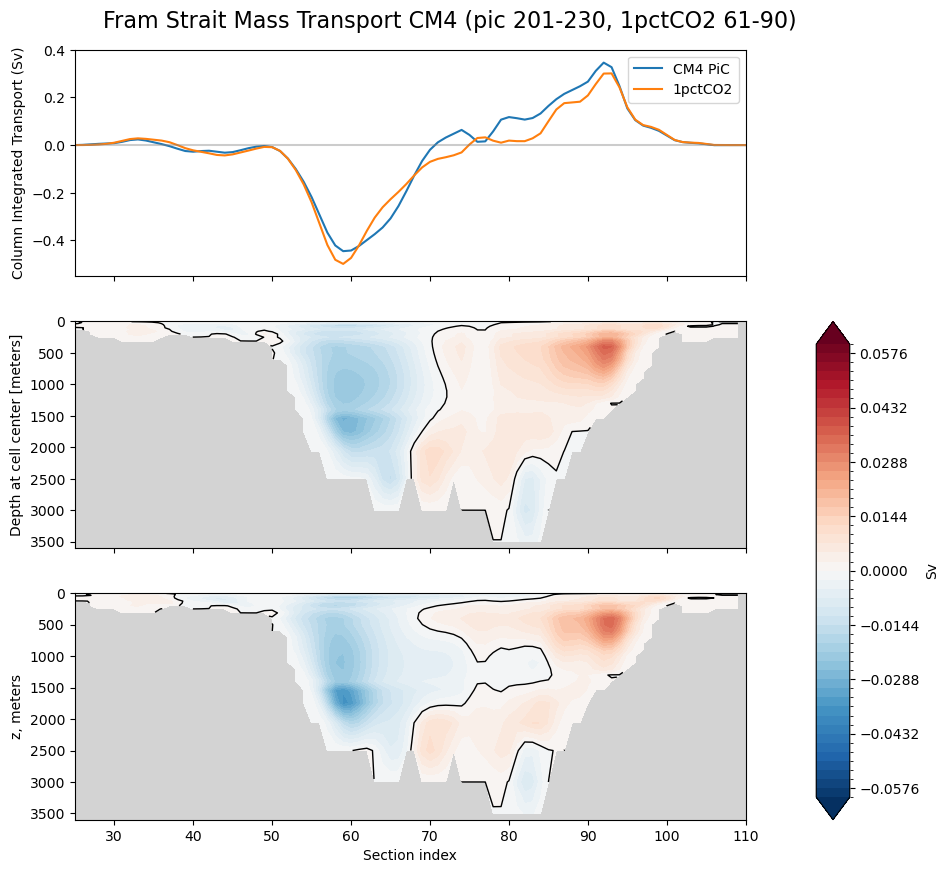

In [88]:
cm4_pic = mass_transport_cm4pic['conv_mass_transport'] * -1
cm4_1pct = mass_transport_cm4_60_90['conv_mass_transport'] * -1
cm4_pic_sum = cm4_pic.sum('z_l')
cm4_1pct_sum = cm4_1pct.sum('z_l')
fig = plt.figure(figsize=(10,10))
fig.suptitle("Fram Strait Mass Transport CM4 (pic 201-230, 1pctCO2 61-90)", y=.92, fontsize=16)

gs = GridSpec(3, 2, width_ratios=[20,1], height_ratios=[5,5,5])

ax2 = fig.add_subplot(gs[1, :-1])
ax1 = fig.add_subplot(gs[0, :-1], sharex=ax2)
ax3 = fig.add_subplot(gs[1:, -1])
ax4 = fig.add_subplot(gs[2, :-1], sharex=ax2, sharey=ax2)
ax2.set_facecolor('lightgrey')
ax4.set_facecolor('lightgrey')
cmap = plt.get_cmap('RdBu_r').copy()
# top panel

cm4_pic_sum.plot(x='sect', ax=ax1, label='CM4 PiC')
cm4_1pct_sum.plot(x='sect', ax=ax1, label='1pctCO2')
ax1.set_ylim(-.55, 0.4)
ax1.axhline(0, color='gray', alpha=.4)
ax1.set_ylabel('Column Integrated Transport (Sv)')
ax1.legend()

# middle panel
cm4_pic_plot = cm4_pic.plot.contourf(
    x='sect', y='z_l',
    levels=51, cmap=cmap,
    vmin=-.06, vmax=.06,
    extend='both',
    ax=ax2,
    add_colorbar=False
)
cm4_pic.plot.contour(
    x='sect', y='z_l',
    levels=[0],
    colors='k',
    linewidths=1,
    ax=ax2
)

ax2.set_xlim(25, 110)
ax2.set_ylim(3600, 0)

# last panel 
cm4_1pct_plot = cm4_1pct.plot.contourf(
    x='sect', y='z_l',
    levels=51, cmap=cmap,
    vmin=-.06, vmax=.06,
    extend='both',
    ax=ax4,
    add_colorbar=False
)

cm4_1pct.plot.contour(
    x='sect', y='z_l',
    levels=[0],
    colors='k',
    linewidths=1,
    ax=ax4
)

ax2.label_outer()
ax1.label_outer()
ax4.label_outer()
ax4.set_xlim(25, 110)
ax4.set_ylim(3600, 0)

ax4.set_xlabel('Section index')
ax4.set_ylabel('z, meters')

fig.colorbar(cs, cax=ax3)
ax3.set_ylabel('Sv')   # optional label
#plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/smooth_Convective_Mass_Transport_FS_CM4_1pctCO2_61_90yr_z.png")

## Cross Section delta

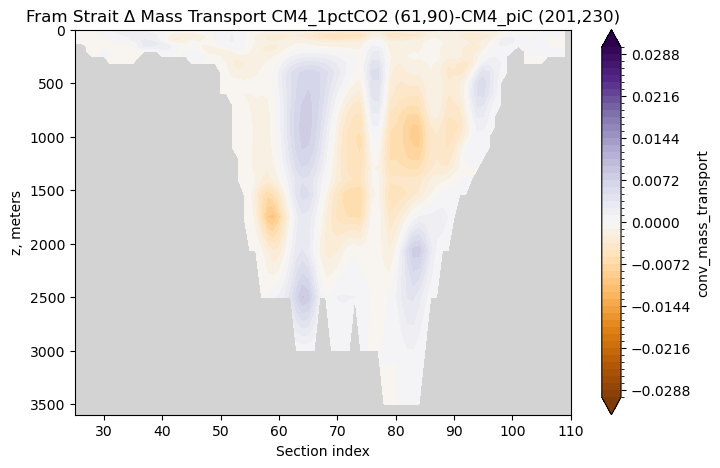

In [23]:
diff = (mass_transport_cm4_60_90 * -1) - (mass_transport_cm4pic * -1)
fig, ax = plt.subplots(figsize=(8,5))
da = diff['conv_mass_transport']
ax.set_facecolor('lightgrey')
cmap = plt.get_cmap('PuOr').copy()

da.plot.contourf(
    x='sect',
    y='z_l',
    levels=51,
    cmap=cmap,
    vmin=-.03,
    vmax=.03,
    extend='both',
    ax=ax
)

ax.set_xlim(25, 110)
ax.set_ylim(3600, 0)
ax.set_xlabel('Section index')
ax.set_ylabel('z, meters')
ax.set_title('Fram Strait Δ Mass Transport CM4_1pctCO2 (61,90)-CM4_piC (201,230)', fontsize=12)
plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/smooth_delta_Convective_Mass_Transport_FS_CM4piC_201_230yr_z.png")

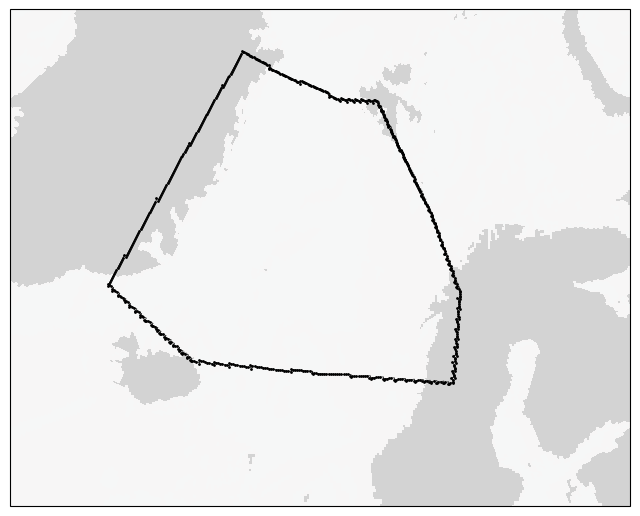

In [14]:
fig, ax = plt.subplots(
    figsize=(8,8),
    subplot_kw={'projection': ccrs.NorthPolarStereo()}
)
ax.set_facecolor('lightgray')
ds_above50 = ds_vmo_mean.where(ds_vmo_mean.yq >= 50, np.nan)
da = ds_above50.vmo.isel(z_l=0)
lon = static_ds.geolon
lat = static_ds.geolat

pcm = ax.pcolormesh(
    lon, lat, da.values,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', vmin=-1e10, vmax=1e10
    
)

ax.plot(reg.loop(region.lons), reg.loop(region.lats), "k-", linewidth=0.5, transform=ccrs.PlateCarree())
ax.plot(region.lons_uv, region.lats_uv, "k.", markersize=2., transform=ccrs.PlateCarree())
ax.set_extent([-30, 30, 60, 83], crs=ccrs.PlateCarree())


## BSO

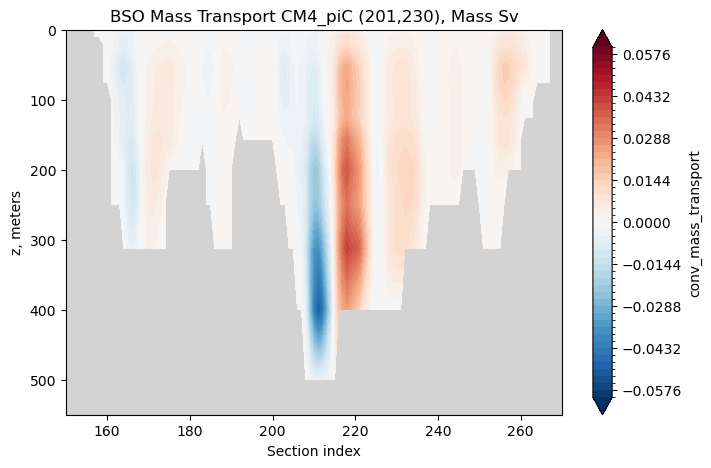

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
da = mass_transport_cm4pic['conv_mass_transport'] * -1 
ax.set_facecolor('lightgrey')
cmap = plt.get_cmap('RdBu_r').copy()

da.plot.contourf(
    x='sect',
    y='z_l',
    levels=51,
    cmap=cmap,
    vmin=-.06,
    vmax=.06,
    extend='both',
    ax=ax
)

ax.set_xlim(150, 270)
ax.set_ylim(550, 0)
ax.set_xlabel('Section index')
ax.set_ylabel('z, meters')
ax.set_title('BSO Mass Transport CM4_piC (201,230), Mass Sv')
plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/smooth_Convective_Mass_Transport_BSO_CM4piC_201_230yr_z.png")

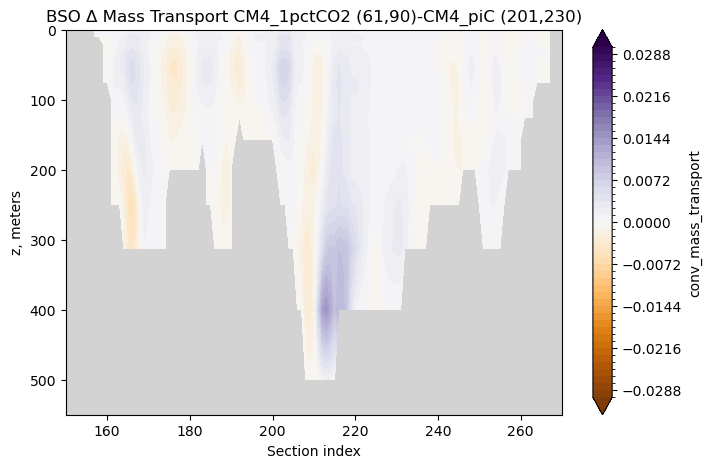

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
da = diff['conv_mass_transport']
ax.set_facecolor('lightgrey')
cmap = plt.get_cmap('PuOr').copy()

da.plot.contourf(
    x='sect',
    y='z_l',
    levels=51,
    cmap=cmap,
    vmin=-.03,
    vmax=.03,
    extend='both',
    ax=ax
)

ax.set_xlim(150, 270)
ax.set_ylim(550, 0)
ax.set_xlabel('Section index')
ax.set_ylabel('z, meters')
ax.set_title('BSO Δ Mass Transport CM4_1pctCO2 (61,90)-CM4_piC (201,230)', fontsize=12)
plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/smooth_delta_Convective_Mass_Transport_BSO_CM4piC_201_230yr_z.png")

## south_east_entrance

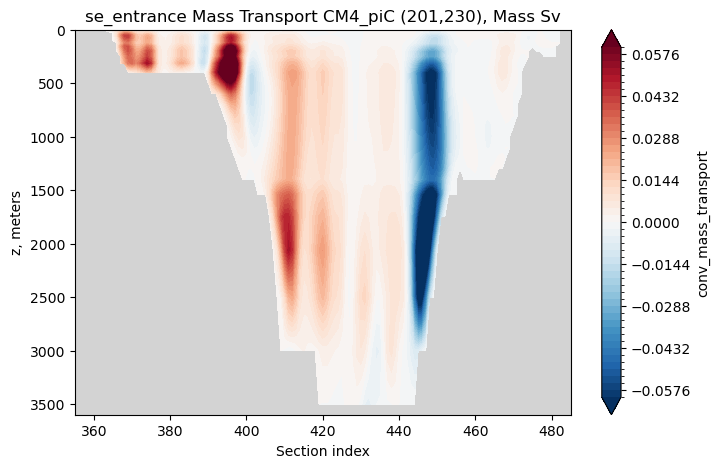

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
da = mass_transport_cm4pic['conv_mass_transport']
ax.set_facecolor('lightgrey')
cmap = plt.get_cmap('RdBu_r').copy()

da.plot.contourf(
    x='sect',
    y='z_l',
    levels=51,
    cmap=cmap,
    vmin=-.06,
    vmax=.06,
    extend='both',
    ax=ax
)

ax.set_xlim(355, 485)
ax.set_ylim(3600, 0)
ax.set_xlabel('Section index')
ax.set_ylabel('z, meters')
ax.set_title('se_entrance Mass Transport CM4_piC (201,230), Mass Sv')
plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/smooth_Convective_Mass_Transport_se_entrance_CM4piC_201_230yr_z.png")

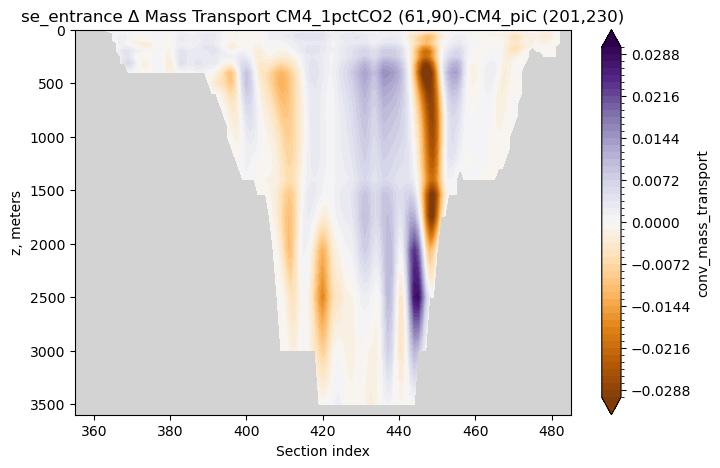

In [18]:
diff_btm = ((mass_transport_cm4_60_90) - (mass_transport_cm4pic)).copy(deep=True)
fig, ax = plt.subplots(figsize=(8,5))
da = diff_btm['conv_mass_transport']
ax.set_facecolor('lightgrey')
cmap = plt.get_cmap('PuOr').copy()

da.plot.contourf(
    x='sect',
    y='z_l',
    levels=51,
    cmap=cmap,
    vmin=-.03,
    vmax=.03,
    extend='both',
    ax=ax
)

ax.set_xlim(355, 485)
ax.set_ylim(3600, 0)
ax.set_xlabel('Section index')
ax.set_ylabel('z, meters')
ax.set_title('se_entrance Δ Mass Transport CM4_1pctCO2 (61,90)-CM4_piC (201,230)', fontsize=12)
plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/smooth_delta_Convective_Mass_Transport_se_entrance_CM4piC_201_230yr_z.png")

## denmark strait

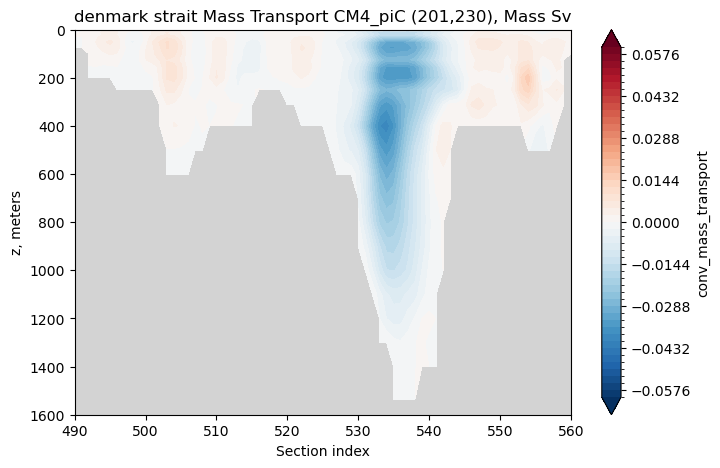

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
da = mass_transport_cm4pic['conv_mass_transport']
ax.set_facecolor('lightgrey')
cmap = plt.get_cmap('RdBu_r').copy()

da.plot.contourf(
    x='sect',
    y='z_l',
    levels=51,
    cmap=cmap,
    vmin=-.06,
    vmax=.06,
    extend='both',
    ax=ax
)

ax.set_xlim(490, 560)
ax.set_ylim(1600, 0)
ax.set_xlabel('Section index')
ax.set_ylabel('z, meters')
ax.set_title('denmark strait Mass Transport CM4_piC (201,230), Mass Sv')
plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/smooth_Convective_Mass_Transport_ds_CM4piC_201_230yr_z.png")

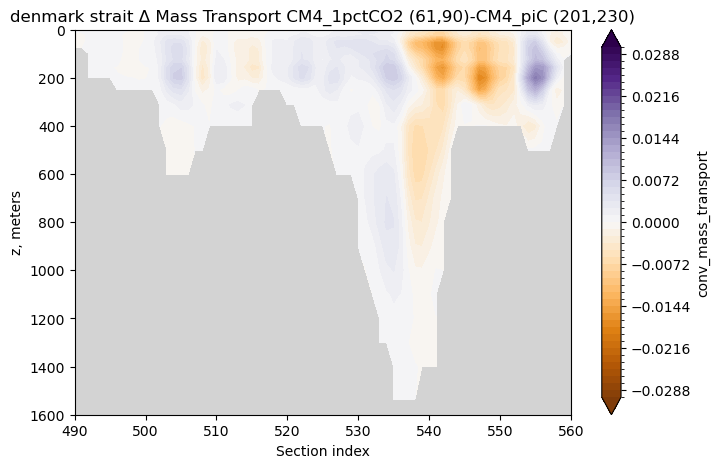

In [20]:
diff_btm = ((mass_transport_cm4_60_90) - (mass_transport_cm4pic)).copy(deep=True)
fig, ax = plt.subplots(figsize=(8,5))
da = diff_btm['conv_mass_transport']
ax.set_facecolor('lightgrey')
cmap = plt.get_cmap('PuOr').copy()

da.plot.contourf(
    x='sect',
    y='z_l',
    levels=51,
    cmap=cmap,
    vmin=-.03,
    vmax=.03,
    extend='both',
    ax=ax
)

ax.set_xlim(490, 560)
ax.set_ylim(1600, 0)
ax.set_xlabel('Section index')
ax.set_ylabel('z, meters')
ax.set_title('denmark strait Δ Mass Transport CM4_1pctCO2 (61,90)-CM4_piC (201,230)', fontsize=12)
plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/smooth_delta_Convective_Mass_Transport_ds_CM4piC_201_230yr_z.png")

## $\psi$

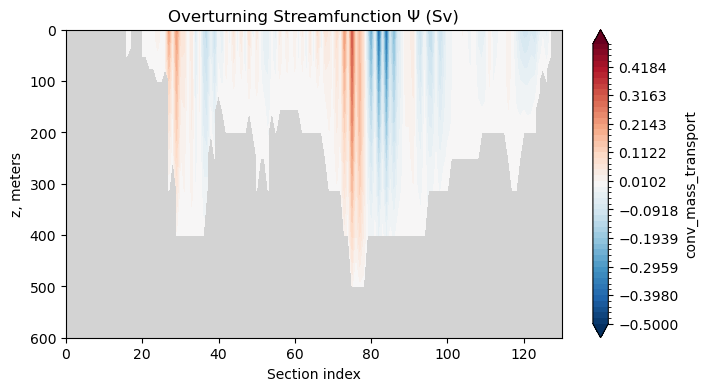

In [114]:
fig, ax = plt.subplots(figsize=(8,4))
da = mass_transport_cm4pic['conv_mass_transport']
psi = da[::-1, :].cumsum(dim='z_l')[::-1, :]
psi = psi.where(psi!=0, np.nan)
ax.set_facecolor('lightgrey')

cf = psi.plot.contourf(
    x='sect',
    y='z_l',
    levels=50,
    cmap='RdBu_r',
    extend='both',
    ax=ax, vmin=-.5, vmax=.5
)

ax.set_xlim(0, 130)
ax.set_ylim(600, 0)
ax.set_xlabel('Section index')
ax.set_ylabel('z, meters')
ax.set_title('Overturning Streamfunction Ψ (Sv)')
plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/stream_function_BSO_CM4piC_201_230yr_z.png")